This a series of scripts to retrieve data from a government source.
The file includes data about how much money was received from federal and state
government in my County.

It needs to be processed because the data comes as text and tables in an scanned document.

Yes I will be using AI to generate code to extract the data from here, the point is to model an interesting set
of data using graphql and constructing an interesting API.

In [1]:
import fitz  
from PIL import Image
import pytesseract
import io
from IPython.display import display


pdf_path = "cajeme_presupuesto.pdf"
doc = fitz.open(pdf_path)

We wil be parsing from page 7 to 10.
First lets load one page and show it to the screen.

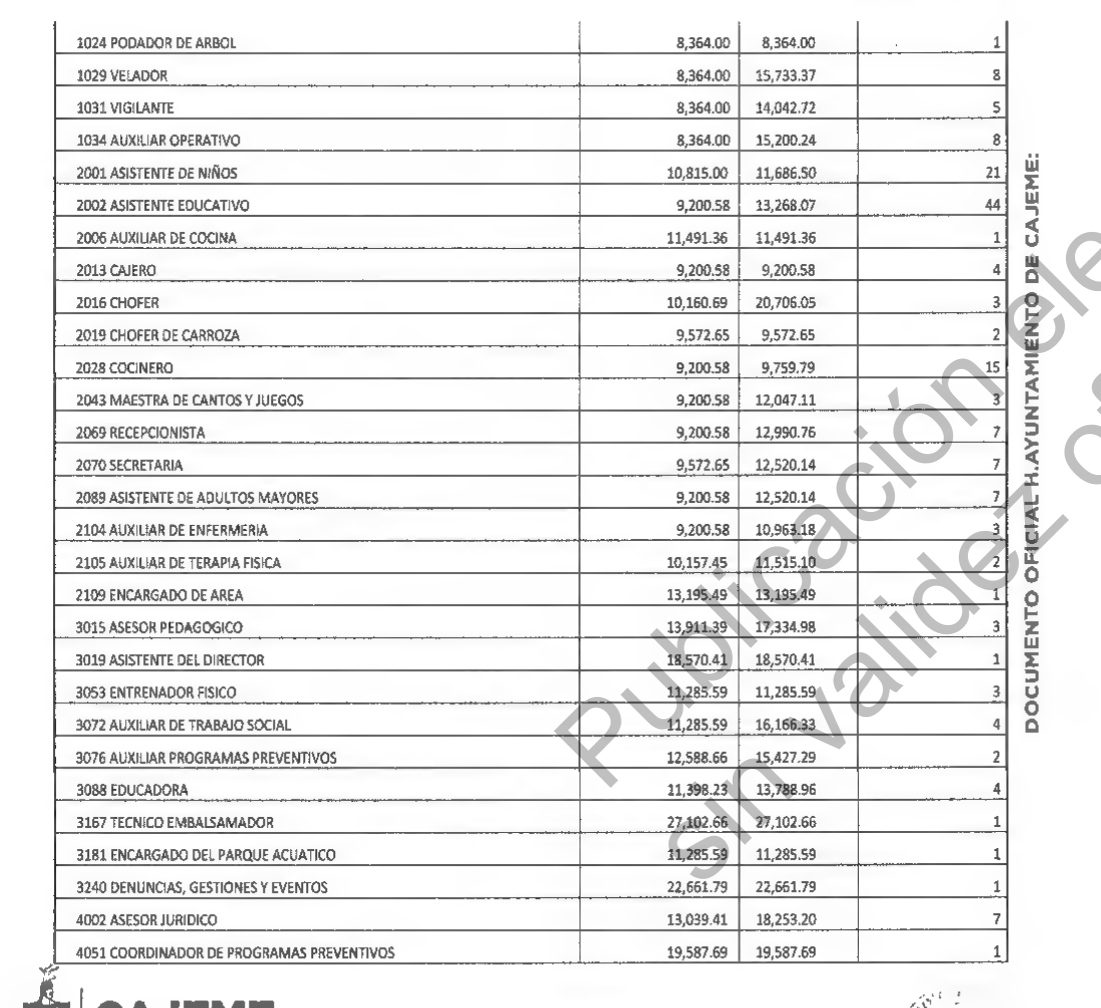

In [ ]:
tabla_salarios_png = []
for i in range(18, 28):
    page = doc[i]
    pix = page.get_pixmap(dpi=300)
    img = Image.open(io.BytesIO(pix.tobytes("png")))
    img_cropped = img.crop((250, 600, img.width - 100, img.height - 400))
    mid_x = img_cropped.width // 2
    left_half = img_cropped.crop((0, 0, mid_x, img_cropped.height))
    right_half = img_cropped.crop((mid_x, 0, img_cropped.width, img_cropped.height))
    tabla_salarios_png.append(left_half)
    tabla_salarios_png.append(right_half)

SCALE = 1
img_small = tabla_salarios_png[-2].resize(
    (tabla_salarios_png[1].width // SCALE, tabla_salarios_png[1].height // SCALE)
)
display(img_small)
API_KEY = open(".env").read().split("API_KEY=")[1].splitlines()[0]

Lets define the rules on how to parse the text and the table here. 
* 1.- 4 digit numbers define a category.
* 2.- 5 digit numbers define an activity belonging to a certain category.

In [15]:
PARSE_IMAGES = False

if PARSE_IMAGES:
    import openai
    import base64
    import io

    def pil_to_base64(img):
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")

    client = openai.OpenAI(api_key=API_KEY)

    prompt = """
        Extract the following data. The first number is the ID of the Employee. Then the name of the position.
        The first number is Lower Salary Band, Then Upper salary band. Then a 1 or 2 digit number is the amount of employees
        at that position. With the image shown, extract the following data:
        {"position_id": 5 , "position" : "empleado domestico" , "lower_wage": 18000 , "upper_wage" : 19000 , "employee_count": 3 }
        Format is .jsonl
        
    """

    responses = []
    for img in tabla_salarios_png:
        img_b64 = pil_to_base64(img)
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_b64}"}}
                    ]
                }
            ],
            max_tokens=3000
        )
        responses.append(response.choices[0].message.content)

    with open("responses.txt", "w", encoding="utf-8") as f:
        for content in responses:
            f.write(content + "\n")

Manualmente tuve que remover ciertos caracteres. Pero se realizo un JSON con los datos. 

In [13]:
import json

with open("sueldos_cajeme_2025.json", "r", encoding="utf-8") as fp:
    data = json.load(fp)

data.sort(key = lambda x : x["employee_count"] , reverse=True)

for d in data:
    d["position"] = d["position"].upper()

Ver ciertas estadisticas rapidas: 

In [25]:
seen = set()
unique_data = []
for d in data:
    if d["position_id"] not in seen:
        unique_data.append(d)
        seen.add(d["position_id"])

grouped = {}
for d in unique_data:
    cat = str(d["position_id"])[0] + "000"
    if cat not in grouped:
        grouped[cat] = []
    else:
        grouped[cat].append(d)

category_names = {
    "8000": "CUERPOS DE SEGURIDAD Y ALTOS FUNCIONARIOS",
    "7000": "DIRECCIONES Y SECRETARÍAS MUNICIPALES",
    "6000": "OBRA, PROTECCIÓN CIVIL Y EMPLEADOS PÚBLICOS",
    "5000": "COORDINACIONES Y JEFATURAS",
    "4000": "COORDINADORES Y ARCHIVO MUNICIPAL",
    "3000": "ENCARGADOS Y COORDINADORES ADMINISTRATIVOS",
    "2000": "SUPERVISORES, AUXILIARES Y CAJEROS",
    "1000": "PERSONAL OPERATIVO Y VIGILANCIA"
}

named_grouped = {}
for k, v in grouped.items():
    name = category_names.get(k, "OTROS")
    key = f'{k} : {name}'
    named_grouped[key] = v

with open("sueldos_grouped.json", "w", encoding="utf-8") as fp:
    json.dump(named_grouped, fp, indent=2, ensure_ascii=False)